<a href="https://colab.research.google.com/github/lrav35/diffusion/blob/main/QuickDiffusionModel_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
IMG_SIZE = 32
BATCH_SIZE = 64
FIG_SIZE = (9, 9)
category = 5 # dogs
timesteps = 32
num_images = 36
time_bar = 1 - np.linspace(0, 1., timesteps + 1)

In [3]:
# load data and split into train and test
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train[y_train.squeeze() == category]  # only dog images
X_train = X_train / 127.5 - 1.0  # scale to -1 to 1

170498071/170498071 [==============================] - 3s 0us/step


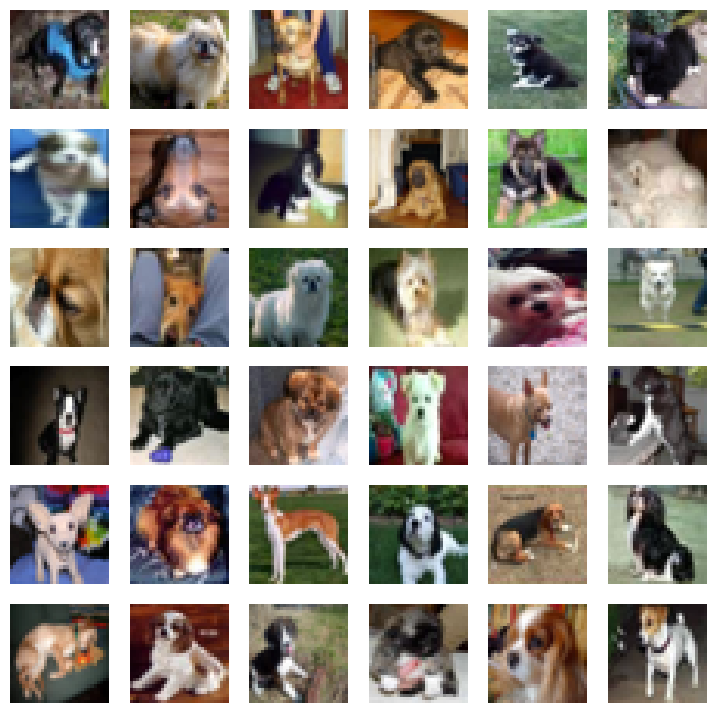

In [10]:
show_examples(X_train)

In [4]:
# functions for viewing images
def show_examples(data, num_images=num_images):
  # displays example images in a grid format
  plt.figure(figsize=FIG_SIZE)
  grid_size = int(np.sqrt(num_images))
  for i in range(num_images):
    plt.subplot(grid_size, grid_size, i + 1)
    img = scale(data[i])
    plt.imshow(img)
    plt.axis('off')

def scale(img):
    # min-max scaling
    img = img - img.min()
    img = img / img.max()
    return img

In [5]:
# util functions
def generate_ts(num):
  # generates random timesteps
  return np.random.randint(0, timesteps, size=num)

In [6]:
# forward noise
def forward_noise(img, ts):
  # slowly adds noise to images
  current_time = time_bar[ts]
  next_time = time_bar[ts + 1]

  noise = np.random.normal(size=img.shape)  # noise mask

  new_shape = tuple([-1] + [1 for _ in range(img.ndim - 1)])
  current_time = current_time.reshape(new_shape)
  next_time = next_time.reshape(new_shape)

  current_img = img * (1 - current_time) + noise * current_time
  next_img = img * (1 - next_time) + noise * next_time
  return current_img, next_img

In [14]:
ts = generate_ts(num_images)
current_imgs, next_imgs = forward_noise(X_train[:num_images], ts)

In [16]:
class UNetBlock(keras.layers.Layer):
  def __init__(self, filters=128, kernel_size=3, activation='relu'):
    super().__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.activation = activation
    self.conv2d = keras.layers.Conv2D(self.filters, kernel_size=self.kernel_size, padding='same')

  def call(self, x_img, x_ts):
    x_param = self.conv2d(x_img)
    x_param = keras.layers.Activation(self.activation)(x_param)

    time_param = keras.layers.Dense(self.filters, activation=self.activation)(x_ts)
    time_param = keras.layers.Reshape((1, 1, self.filters))(time_param)

    x_param = x_param * time_param

    x_out = self.conv2d(x_img)
    x_out = x_out + x_param
    x_out = keras.layers.LayerNormalization()(x_out)
    x_out = keras.layers.Activation(self.activation)(x_out)

    return x_out

In [18]:
class MLPBlock(keras.layers.Layer):
  def __init__(self):
    super().__init__()

  def call(self, x, ts):
    x = keras.layers.Flatten()(x)
    x = keras.layers.Concatenate()([x, ts])
    x = keras.layers.Dense(128)(x)
    x = keras.layers.LayerNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dense(512)(x)
    x = keras.layers.LayerNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Reshape((4, 4, 32))(x)
    return x

In [30]:
class SimpleUNet(keras.Model):
  def __init__(self):
    super().__init__()
    self.maxpool2d = keras.layers.MaxPool2D(2)
    self.concat = keras.layers.Concatenate()
    self.upsample2d = keras.layers.UpSampling2D(2)

  def call(self):
    self.x_input = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')
    self.X_ts_input = keras.Input(shape=(1,), name='x_ts_input')

    x = self.x_input
    x_ts = self.x_ts_input

    x_ts = keras.layers.Dense(192)(x_ts)
    x_ts = keras.layers.LayerNormalization()(x_ts)
    x_ts = keras.layers.Activation('relu')(x_ts)

    x = x32 = UNetBlock()(x, x_ts)
    x = self.maxpool2d(x)

    x = x16 = UNetBlock()(x, x_ts)
    x = self.maxpool2d(x)

    x = x8 = UNetBlock()(x, x_ts)
    x = self.maxpool2d(x)

    x = x4 = UNetBlock()(x, x_ts)

    x = MLPBlock()(x)

    x = self.concat([x, x4])
    x = UNetBlock()(x, x_ts)
    x = self.upsample2d(x)

    x = self.concat([x, x8])
    x = UNetBlock()(x, x_ts)
    x = self.upsample2d(x)

    x = self.concat([x, x16])
    x = UNetBlock()(x, x_ts)
    x = self.upsample2d(x)

    x = self.concat([x, x32])
    x = UNetBlock()(x, x_ts)

    x = keras.layers.Conv2D(3, kernel_size=1, padding='same')(x)

    return x


In [31]:
unet = SimpleUNet()